In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

In [4]:
data = pd.read_csv('../data/sunflares.csv')

In [5]:
# Convertir las columnas de fecha a formato datetime
data['start.date'] = pd.to_datetime(data['start.date'])
data['peak'] = pd.to_datetime(data['peak'])

/var/folders/tt/5swmzhn10p3c6xwhpwvkw6w40000gn/T/ipykernel_4056/2746386061.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['peak'] = pd.to_datetime(data['peak'])


In [6]:
# Ordenar el DataFrame por fecha de inicio
data.sort_values(by='start.date', inplace=True)

In [7]:
data.head()

,flare,start.date,start.time,peak,end,duration.s,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial,active.region.ar,flag.1,flag.2,flag.3,flag.4,flag.5
0,2021213,2002-02-12,21:29:56,2024-05-13 21:33:38,21:41:48,712,136,167304,12-25,592,-358,692,0,A1,P1,NaN,NaN,NaN
1,2021228,2002-02-12,21:44:08,2024-05-13 21:45:06,21:48:56,288,7,9504,6-12,604,-341,694,9811,A1,P1,PE,Q1,NaN
11,2021355,2002-02-13,23:31:56,2024-05-13 23:34:06,23:52:56,1260,56,91896,12-25,-230,299,378,0,A1,P1,PE,Q1,NaN
10,2021329,2002-02-13,23:28:32,2024-05-13 23:30:38,23:31:56,204,18,14688,12-25,-237,295,379,9825,A1,P1,PE,Q1,NaN
9,2021313,2002-02-13,12:29:32,2024-05-13 12:30:58,12:33:24,232,26,16920,12-25,-905,-375,980,0,A1,P1,NaN,NaN,NaN


In [8]:
# Agregar las erupciones solares por mes
data['year_month'] = data['start.date'].dt.to_period('M')

In [9]:
# Agregar el conteo de erupciones solares por mes
erupciones_por_mes = data.groupby('year_month').size()

In [10]:
erupciones_por_mes.head()

year_month
2002-02     231
2002-03     571
2002-04     493
2002-05    1165
2002-06     388
Freq: M, dtype: int64

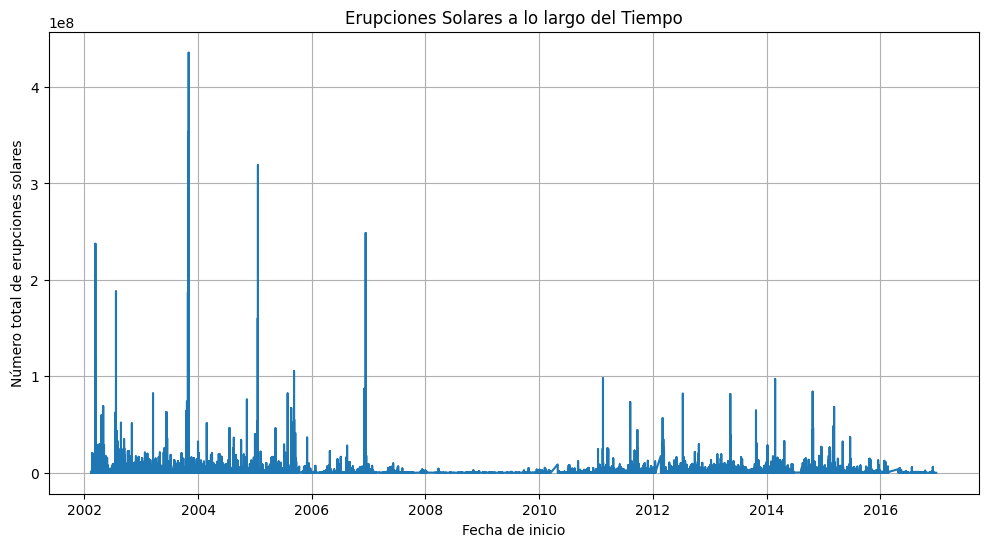

In [11]:
# Graficar la serie de tiempo de erupciones solares
plt.figure(figsize=(12, 6))
plt.plot(data['start.date'], data['total.counts'])
plt.title('Erupciones Solares a lo largo del Tiempo')
plt.xlabel('Fecha de inicio')
plt.ylabel('Número total de erupciones solares')
plt.grid(True)
plt.show()

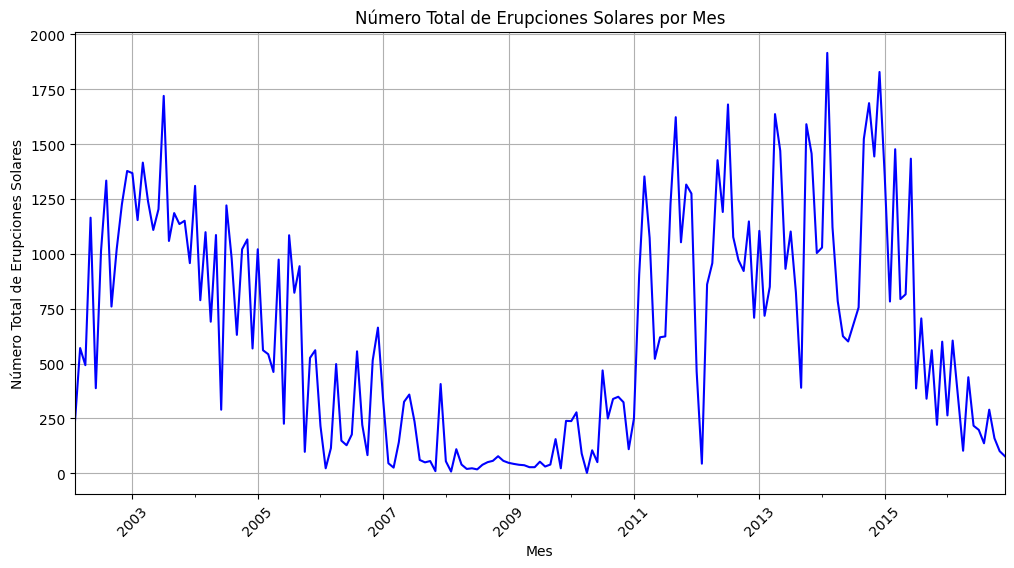

In [12]:
# Graficar el número total de erupciones solares por mes
plt.figure(figsize=(12, 6))
erupciones_por_mes.plot(kind='line', color='b', linestyle='-')
plt.title('Número Total de Erupciones Solares por Mes')
plt.xlabel('Mes')
plt.ylabel('Número Total de Erupciones Solares')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

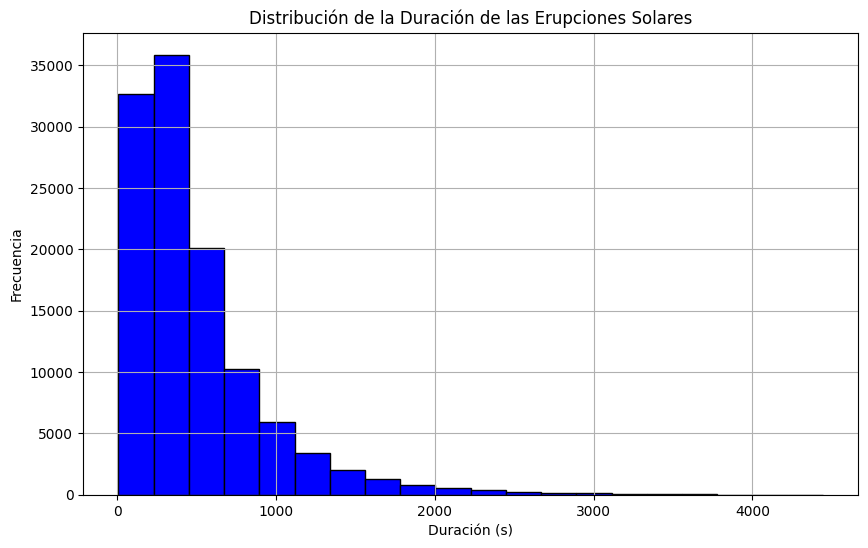

In [13]:
# Gráfico de distribución de la duración de las erupciones solares
plt.figure(figsize=(10, 6))
plt.hist(data['duration.s'], bins=20, color='blue', edgecolor='black')
plt.title('Distribución de la Duración de las Erupciones Solares')
plt.xlabel('Duración (s)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


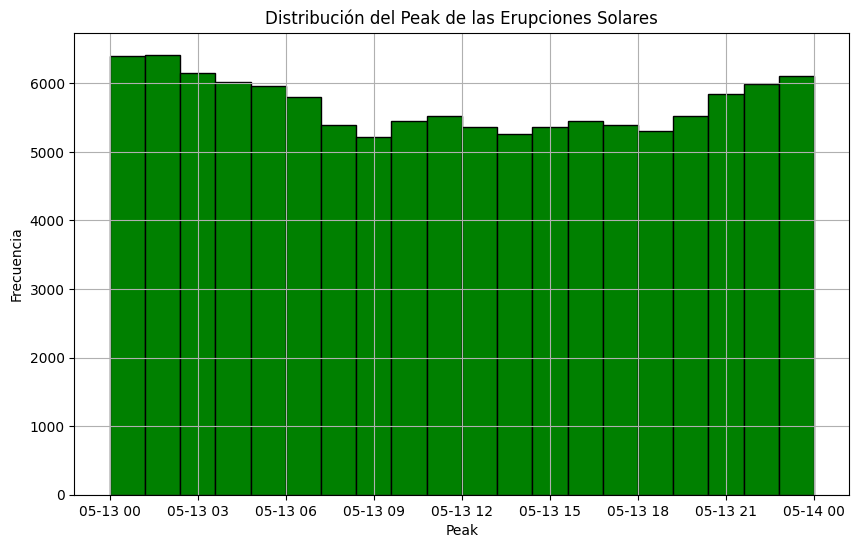

In [14]:
# Gráfico de distribución del peak de las erupciones solares
plt.figure(figsize=(10, 6))
plt.hist(data['peak'], bins=20, color='green', edgecolor='black')
plt.title('Distribución del Peak de las Erupciones Solares')
plt.xlabel('Peak')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

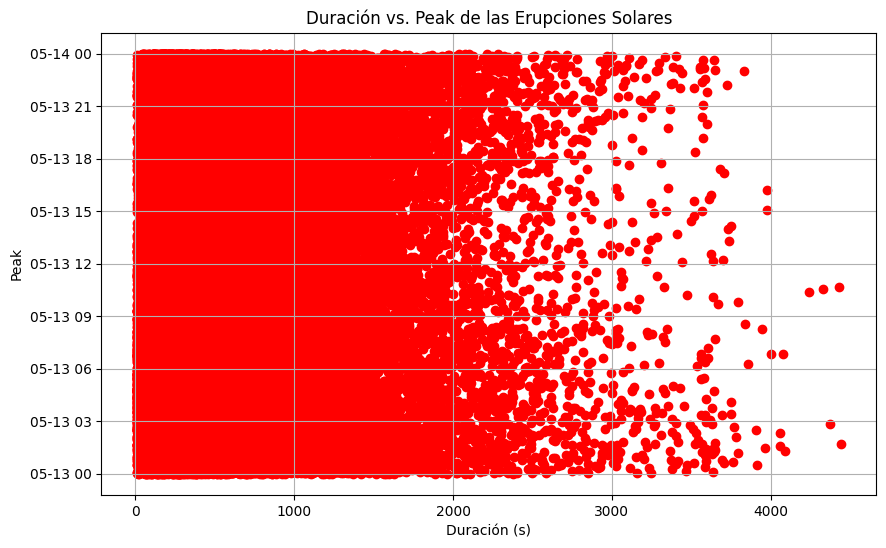

In [15]:
# Gráfico de dispersión de duración vs. peak
plt.figure(figsize=(10, 6))
plt.scatter(data['duration.s'], data['peak'], color='red')
plt.title('Duración vs. Peak de las Erupciones Solares')
plt.xlabel('Duración (s)')
plt.ylabel('Peak')
plt.grid(True)
plt.show()

In [16]:
# Dividir los datos en entrenamiento y prueba
train_size = int(len(erupciones_por_mes) * 0.8)
train, test = erupciones_por_mes.iloc[:train_size], erupciones_por_mes.iloc[train_size:]

In [17]:
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()

In [18]:
# Hacer predicciones sobre los datos de prueba
predictions = model_fit.forecast(steps=len(test))

In [19]:
predictions[:5]

2013-11    1368.508475
2013-12    1137.721388
2014-01    1116.733588
2014-02    1211.875523
2014-03     850.031832
Freq: M, Name: predicted_mean, dtype: float64

In [20]:
# Calcular el error cuadrático medio
mse = np.mean((predictions - test.values)**2)
print('Error cuadrático medio:', mse)

Error cuadrático medio: 413949.6782550723


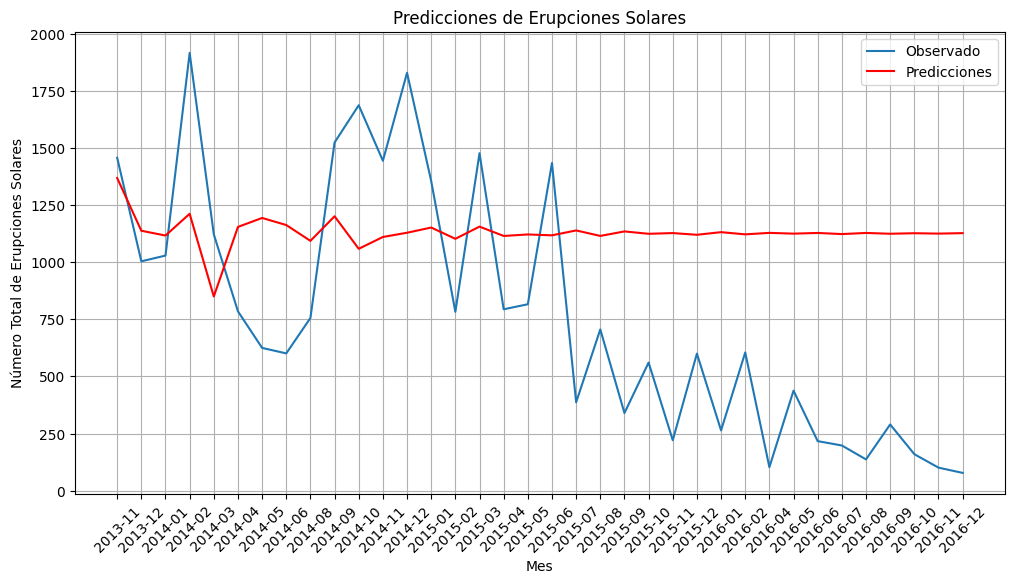

In [21]:
# Convertir los períodos a cadenas de texto
test_index_str = test.index.strftime('%Y-%m')

# Graficar las predicciones
plt.figure(figsize=(12, 6))
plt.plot(test_index_str, test.values, label='Observado')
plt.plot(test_index_str, predictions, color='red', label='Predicciones')
plt.title('Predicciones de Erupciones Solares')
plt.xlabel('Mes')
plt.ylabel('Número Total de Erupciones Solares')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [22]:
from pmdarima import auto_arima

In [23]:
stepwise_fit = auto_arima(data['total.counts'], start_p=1, start_q=1,
                        max_p=3, max_q=3, m=12,
                        start_P=0, seasonal=True,
                        d=None, D=1, trace=True,
                        error_action='ignore',   # we don't want to know if an order does not work 
                        suppress_warnings=True,  # we don't want convergence warnings 
                        stepwise=True)           # set to stepwise

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=112.70 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=3805655.744, Time=6.50 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=3776806.650, Time=44.95 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=85.62 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=3805653.744, Time=6.25 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=3805250.867, Time=7.53 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=3766855.602, Time=104.79 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=273.74 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=99.00 sec


: 

In [ ]:
# To print the summary 
stepwise_fit.summary()